In [9]:
import pandas as pd

# Use relative path since the CSV is in the same folder as the notebook
file_path = 'event_success_dataset.csv'

# Load and inspect the dataset
df = pd.read_csv(file_path)
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_id               836 non-null    int64  
 1   venue_id               836 non-null    int64  
 2   rating                 836 non-null    float64
 3   total_events           836 non-null    int64  
 4   avg_checkins           836 non-null    float64
 5   avg_likes              836 non-null    float64
 6   avg_event_rating       836 non-null    float64
 7   median_event_rating    836 non-null    float64
 8   venue_popularity_tier  836 non-null    int64  
 9   checkin_count          836 non-null    int64  
 10  like_count             836 non-null    int64  
 11  rating_avg             836 non-null    float64
 12  rating_count           836 non-null    int64  
 13  engagement             836 non-null    float64
 14  event_weekday          836 non-null    int64  
 15  event_

(None,
    event_id  venue_id  rating  total_events  avg_checkins  avg_likes  \
 0         2        72     4.7            41     20.170732  39.048780   
 1         8        80     4.3            27     19.481481  37.703704   
 2         9       195     3.2            37     18.864865  36.810811   
 3        10       136     3.2            30     18.633333  36.266667   
 4        11        41     4.8            35     20.428571  40.142857   
 
    avg_event_rating  median_event_rating  venue_popularity_tier  \
 0          3.564462             3.625000                      5   
 1          3.096752             3.285714                      3   
 2          3.120457             3.206897                      2   
 3          3.299544             3.166290                      2   
 4          3.402587             3.592593                      5   
 
    checkin_count  ...  event_month  start_hour  success_score_scaled  \
 0             34  ...            3          21              0.521867 

Trial 15 Complete [00h 00m 07s]
val_mae: 0.01894904114305973

Best val_mae So Far: 0.01522720418870449
Total elapsed time: 00h 01m 26s
Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0047 - mae: 0.0485 - val_loss: 0.0057 - val_mae: 0.0402
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mae: 0.0451 - val_loss: 0.0025 - val_mae: 0.0393
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0474 - val_loss: 0.0018 - val_mae: 0.0263
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0343 - val_loss: 0.0011 - val_mae: 0.0223
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0332 - val_loss: 0.0011 - val_mae: 0.0229
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mae: 0.0272 - val_loss: 9.8284e-04 - val_mae: 0.0233
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0279 - val_loss: 0.0026 - val_mae: 0.0420
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0364 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mae

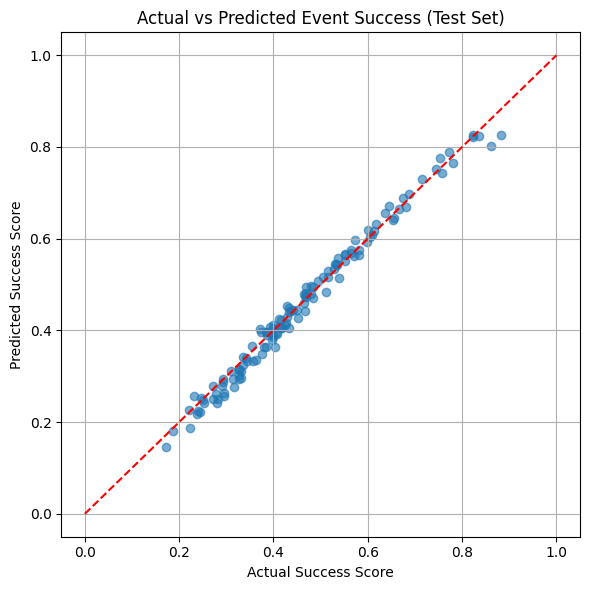

In [10]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
import tensorflow.keras.backend as K
import tensorflow as tf

# --- 1. Load data (already done) ---
# df = pd.read_csv("event_success_dataset.csv")

# --- 2. Prepare inputs ---
tag_columns = [col for col in df.columns if col.startswith("tag_slot_")]
X_tags = df[tag_columns].values.astype(int)
X_num = df.drop(columns=["success_score_scaled", "event_id", "venue_id",] + tag_columns)

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
joblib.dump(scaler, "scaler.pkl")

y = df["success_score_scaled"]
y_min, y_max = y.min(), y.max()
y = (y - y_min) / (y_max - y_min)

# --- 3. Train/Val/Test split ---
Xn_temp, Xn_test, Xt_temp, Xt_test, y_temp, y_test = train_test_split(
    X_num_scaled, X_tags, y, test_size=0.15, random_state=42)

Xn_train, Xn_val, Xt_train, Xt_val, y_train, y_val = train_test_split(
    Xn_temp, Xt_temp, y_temp, test_size=0.1765, random_state=42)

# --- 4. Custom Loss Function ---
def aggressive_penalty_loss(y_true, y_pred):
    error = y_pred - y_true
    base = K.square(error)
    
    # Extra penalty only if prediction overshoots low true values
    over = K.cast(K.less(y_true, 0.3), K.floatx()) * K.square(K.maximum(error, 0)) * 10.0
    
    # Extra penalty only if prediction undershoots high true values
    under = K.cast(K.greater(y_true, 0.7), K.floatx()) * K.square(K.minimum(error, 0)) * 5.0

    return base + over + under

   

# --- 5. Model Builder for KerasTuner ---
max_len = X_tags.shape[1]
num_tags = 51
embedding_dim = 16

def build_model(hp):
    num_input = Input(shape=(Xn_train.shape[1],), name="numeric_input")
    tag_input = Input(shape=(max_len,), name="tag_input")

    tag_emb = Embedding(input_dim=num_tags, output_dim=embedding_dim, mask_zero=True)(tag_input)
    tag_emb = GlobalAveragePooling1D()(tag_emb)

    x = Concatenate()([num_input, tag_emb])

    for i in range(hp.Int("num_layers", 1, 3)):
        x = Dense(units=hp.Int(f"units_{i}", min_value=64, max_value=256, step=32),
                  activation=hp.Choice("activation", ["relu", "tanh"]))(x)
        x = Dropout(rate=hp.Float("dropout", 0.0, 0.4, step=0.1))(x)

    output = Dense(1, activation='linear')(x)
    model = Model(inputs=[num_input, tag_input], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss=aggressive_penalty_loss,
        metrics=["mae"]
    )
    return model

# --- 6. Hyperparameter Tuning ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_logs",
    project_name="event_success_tuning"
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    {"numeric_input": Xn_train, "tag_input": Xt_train},
    y_train,
    validation_data=({"numeric_input": Xn_val, "tag_input": Xt_val}, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# --- 7. Final Training with Best Model ---
best_model = tuner.get_best_models(1)[0]

history = best_model.fit(
    {"numeric_input": Xn_train, "tag_input": Xt_train},
    y_train,
    validation_data=({"numeric_input": Xn_val, "tag_input": Xt_val}, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# --- 8. Evaluation ---
y_pred = best_model.predict({"numeric_input": Xn_test, "tag_input": Xt_test}).flatten()
y_pred_rescaled = y_pred * (y_max - y_min) + y_min
y_test_rescaled = y_test * (y_max - y_min) + y_min

r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)

print(f"\n📊 Evaluation Metrics:")
print(f"R²:  {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")

# --- 9. Plot ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Success Score")
plt.ylabel("Predicted Success Score")
plt.title("Actual vs Predicted Event Success (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 10. Save ---
best_model.save("success_predictor_model_optimized.keras")
with open("y_norm_range.json", "w") as f:
    json.dump([y_min, y_max], f)


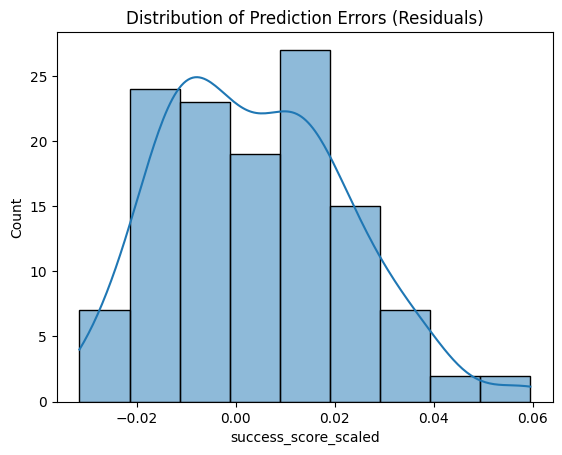

In [11]:
import seaborn as sns
residuals = y_test_rescaled - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.show()


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Use same numeric features used in NN
X = X_num_scaled  # previously scaled numeric input
y_lin = y         # normalized target

# Cross-validation R² scores
scores = cross_val_score(LinearRegression(), X, y_lin, scoring='r2', cv=5)
print("R² scores per fold:", scores)
print("Mean R²:", scores.mean())


R² scores per fold: [0.99474934 0.99730379 0.99761557 0.9976818  0.99667066]
Mean R²: 0.9968042312204289


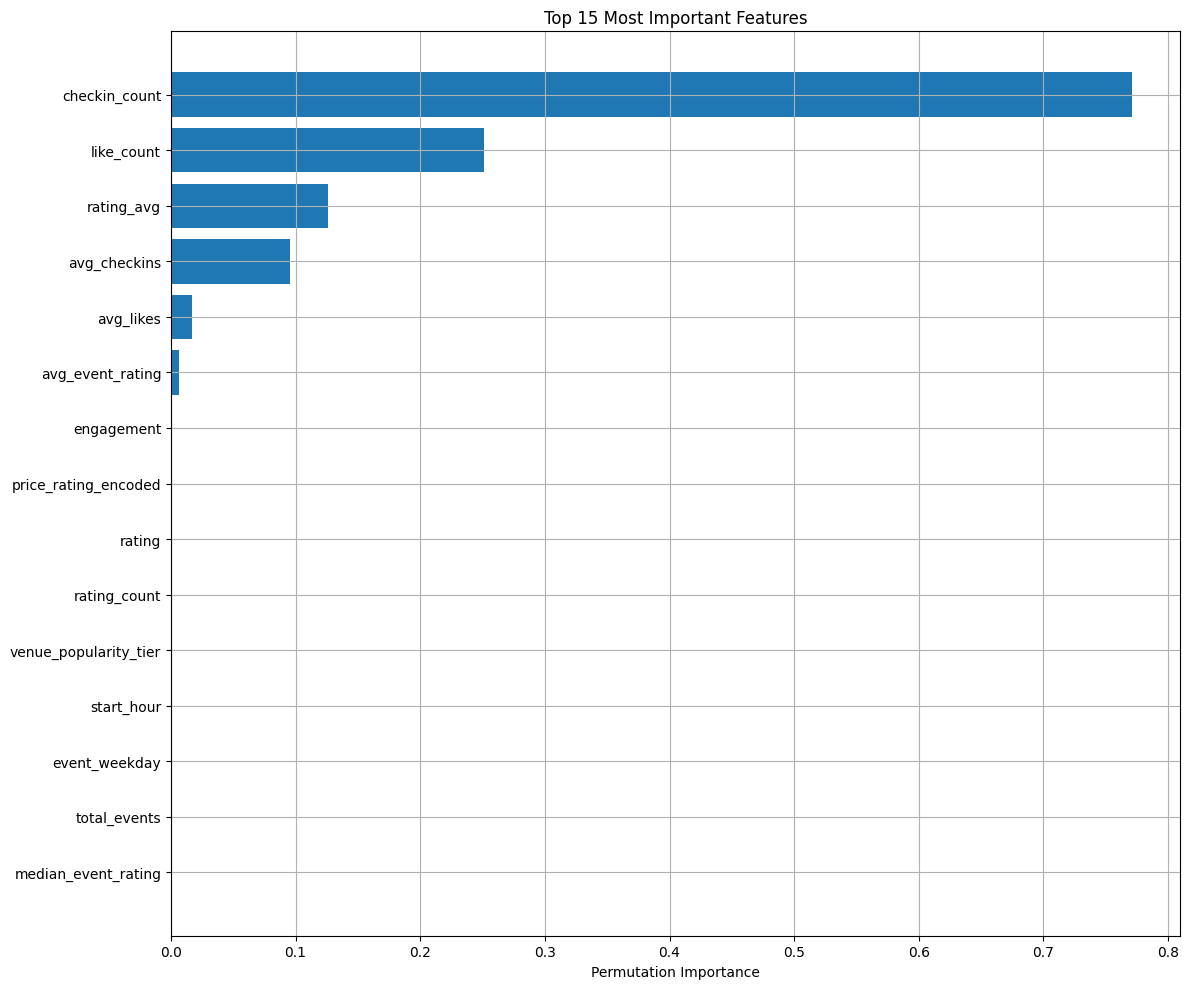

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Fit model
model = LinearRegression()
model.fit(X, y_lin)

# Permutation importance
result = permutation_importance(model, X, y_lin, n_repeats=30, random_state=42)

# Create dataframe of results
importance_df = pd.DataFrame({
    'feature': X_num.columns,  # use correct column names here
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

# Plot
top_n = 15
plt.figure(figsize=(12, 10))
plt.barh(importance_df['feature'][:top_n][::-1], importance_df['importance'][:top_n][::-1])
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Most Important Features")
plt.grid(True)
plt.tight_layout()
plt.show()


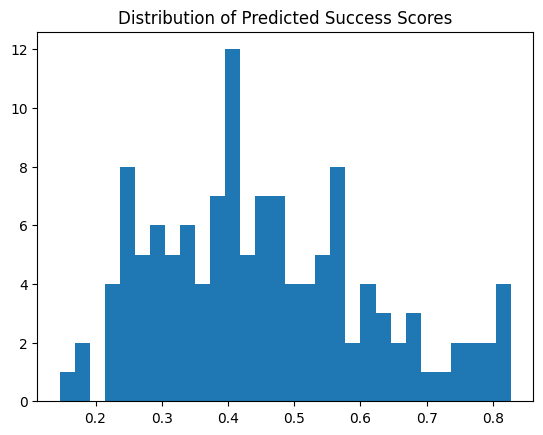

In [14]:
plt.hist(y_pred_rescaled, bins=30)
plt.title("Distribution of Predicted Success Scores")
plt.show()


In [15]:
df["success_score_scaled"].describe()


count    836.000000
mean       0.456898
std        0.156618
min        0.000000
25%        0.352967
50%        0.445031
75%        0.553381
max        1.000000
Name: success_score_scaled, dtype: float64